In [1]:
import os

import pandas as pd

import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report

import cv2

import tensorflow as tf

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU, BatchNormalization

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.optimizers import Adam

from tensorflow.keras import regularizers

import matplotlib.pyplot as plt

import seaborn as sns

import time

from skimage.segmentation import mark_boundaries, slic

from skimage.transform import resize

from lime import lime_image

from tensorflow.keras.preprocessing import image

import random

import warnings

warnings.simplefilter("ignore")

2024-07-18 18:48:20.314611: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-18 18:48:20.314751: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-18 18:48:20.479494: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Define the base path of the dataset

base_path = '/kaggle/input/faceexpressions/dataset'

 

# Load the dataset

data = pd.read_csv('/kaggle/input/faceexpressions/data.csv')

 

# Define the full paths to images

data['path'] = data['path'].apply(lambda x: os.path.join(base_path, x))

 

# Function to get image resolution

def get_image_resolution(img_path):

    if not os.path.exists(img_path):

        return 0, 0

    img = cv2.imread(img_path)

    if img is None:

        return 0, 0

    return img.shape[1], img.shape[0]  # width, height

 

# Add a column for image resolution

data[['width', 'height']] = data['path'].apply(lambda x: pd.Series(get_image_resolution(x)))

 

# Filter images based on the resolution threshold

min_width = 256

min_height = 256

data = data[(data['width'] >= min_width) & (data['height'] >= min_height)]

 

# Add a column for file size

data['file_size'] = data['path'].apply(lambda x: os.path.getsize(x) if os.path.exists(x) else 0)

 

# Sort by file size within each class

data = data.sort_values(by=['label', 'file_size'], ascending=[True, False])

 

# Select the top 1200 images for each class

data = data.groupby('label').head(1200)

 

# Image preprocessing function

def preprocess_image(img_path):

    if not os.path.exists(img_path):

        print(f"Error: File not found at path {img_path}")

        return None

    img = cv2.imread(img_path)

    if img is None:

        print(f"Error: Unable to read image at path {img_path}")

        return None

    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale

    img = cv2.GaussianBlur(img, (3, 3), 0)  # Apply Gaussian Blur

    img = cv2.equalizeHist(img)  # Histogram Equalization

    img = cv2.resize(img, (256, 256))  # Resize to 256x256

    img = img / 255.0  # Normalize pixel values

    return img

 

# Apply preprocessing to all images and filter out any None values

data['image'] = data['path'].apply(preprocess_image)

data = data.dropna(subset=['image'])



In [3]:
# Separate features and labels

X = np.array(data['image'].tolist()).reshape(-1, 256, 256, 1)

label_encoder = LabelEncoder()

y = label_encoder.fit_transform(data['label'])

y = tf.keras.utils.to_categorical(y)

 

# Split the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Data augmentation

datagen = ImageDataGenerator(

    rotation_range=20,

    width_shift_range=0.2,

    height_shift_range=0.2,

    shear_range=0.2,

    zoom_range=0.2,

    horizontal_flip=True

)

In [4]:
# Define the early stopping callback

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

 

# Define the CNN model

model4 = Sequential([

    Conv2D(64, (3, 3), input_shape=(256, 256, 1)),

    BatchNormalization(),

    LeakyReLU(alpha=0.1),

    MaxPooling2D((2, 2)),

    Dropout(0.25),

   

    Conv2D(128, (3, 3)),

    BatchNormalization(),

    LeakyReLU(alpha=0.1),

    MaxPooling2D((2, 2)),

    Dropout(0.25),

   

    Conv2D(256, (3, 3)),

    BatchNormalization(),

    LeakyReLU(alpha=0.1),

    MaxPooling2D((2, 2)),

    Dropout(0.25),

   

    Conv2D(512, (3, 3),name='conv2d_-2'),

    BatchNormalization(),

    LeakyReLU(alpha=0.1),

    MaxPooling2D((2, 2)),

    Dropout(0.25),

   

    Conv2D(512, (3, 3), name='conv2d_last'),

    BatchNormalization(),

    LeakyReLU(alpha=0.1),

    MaxPooling2D((2, 2)),

    Dropout(0.25),

   

    Flatten(),

   

    Dense(256),

    BatchNormalization(),

    LeakyReLU(alpha=0.1),

    Dropout(0.5),

   

    Dense(512),

    BatchNormalization(),

    LeakyReLU(alpha=0.1),

    Dropout(0.5),

   

    Dense(y_train.shape[1], activation='softmax')

])


In [5]:
# Compile the model

model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

start_time = time.time()

 

# Fit the model with early stopping and learning rate reduction

history = model4.fit(

    datagen.flow(X_train, y_train, batch_size=64),

    epochs=20,

    validation_data=(X_test, y_test),

    callbacks=[early_stopping, reduce_lr]

)

elapsed_time = time.time() - start_time

print(f"Elapsed time: {elapsed_time} seconds")

Epoch 1/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 1703s 25s/step - accuracy: 0.2019 - loss: 2.3154 - val_accuracy: 0.2199 - val_loss: 1.9178 - learning_rate: 0.0010
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 1689s 25s/step - accuracy: 0.2426 - loss: 2.0125 - val_accuracy: 0.1435 - val_loss: 1.9139 - learning_rate: 0.0010
Epoch 3/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 1698s 25s/step - accuracy: 0.2787 - loss: 1.8780 - val_accuracy: 0.1380 - val_loss: 2.2908 - learning_rate: 0.0010
Epoch 4/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 1698s 25s/step - accuracy: 0.2917 - loss: 1.7774 - val_accuracy: 0.1389 - val_loss: 2.2776 - learning_rate: 0.0010
Epoch 5/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 1698s 25s/step - accuracy: 0.3003 - loss: 1.6914 - val_accuracy: 0.1472 - val_loss: 2.3665 - learning_rate: 0.0010
Epoch 6/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 1705s 25s/step - accuracy: 0.3292 - loss: 1.6234 - val_accuracy: 0.2208 - val_loss: 2.1257 - learning_rate: 0.0010
Epoch 7/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 1708s 25s/step - accuracy: 0.3759 - loss: 1.

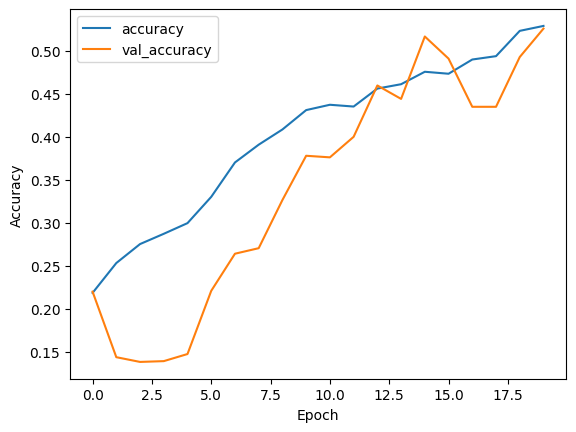

34/34 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step


In [6]:
# Plot training history

plt.plot(history.history['accuracy'], label='accuracy')

plt.plot(history.history['val_accuracy'], label='val_accuracy')

plt.xlabel('Epoch')

plt.ylabel('Accuracy')

plt.legend()

plt.show()

 

# Generate predictions

y_pred4 = model4.predict(X_test)

y_pred_classes4 = np.argmax(y_pred4, axis=1)

y_true = np.argmax(y_test, axis=1)

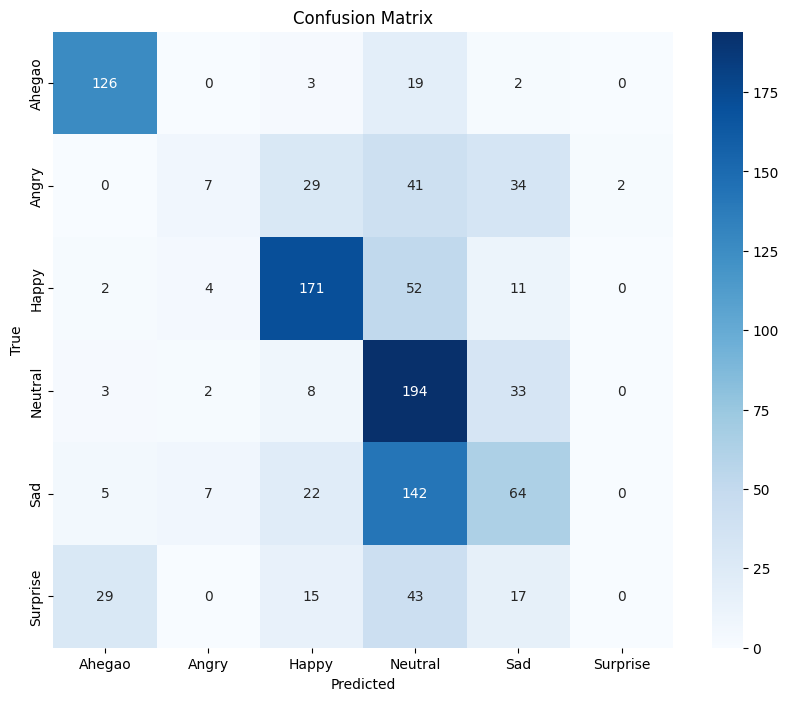

AUC Score: 0.840108718558615
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.84      0.80       150
           1       0.35      0.06      0.11       113
           2       0.69      0.71      0.70       240
           3       0.40      0.81      0.53       240
           4       0.40      0.27      0.32       240
           5       0.00      0.00      0.00       104

    accuracy                           0.52      1087
   macro avg       0.43      0.45      0.41      1087
weighted avg       0.47      0.52      0.46      1087



In [7]:
# Compute confusion matrix

conf_matrix = confusion_matrix(y_true, y_pred_classes4)

 

# Plot confusion matrix

plt.figure(figsize=(10, 8))

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

plt.xlabel('Predicted')

plt.ylabel('True')

plt.title('Confusion Matrix')

plt.show()

# AUC Score

auc = roc_auc_score(y_test, y_pred4, multi_class='ovr')

print('AUC Score:', auc)

 

# Classification Report

print('Classification Report:\n', classification_report(y_true, y_pred_classes4))